# Generate initial conditions for excited-state dynamics based on spatial filtering (SF) approximation

In [2]:
import os
import glob
import random

import numpy as np

import matplotlib.pyplot as plt
import matplotlib

import ase.units as units
from ase.db import connect
from ase.io import Trajectory

import warnings
warnings.filterwarnings('ignore')

# Use custom mpl style
plt.style.use('gialesty-arial2')

In [3]:
def create_morse_potential(r, de, a, re):
    morse_potential = de * (1 - np.exp(- a * (r - re)))**2
    
    return morse_potential

def plot_lines(ax, x, y, labels, colors=None, 
               xlim=None, ylim=None):
    if colors is None:
        colors = ['k', 'r', 'b', 'b']
    
    for i in range(len(y)):
        ax.plot(x, y[i], '-', color=colors[i],
                linewidth=2, label=labels[i])
        
    if xlim is not None:
        ax.set_xlim(xlim[0], xlim[1])
    if ylim is not None:
        ax.set_ylim(ylim[0], ylim[1])


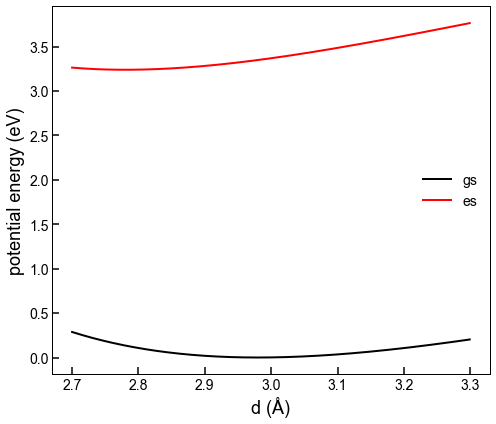

In [4]:
'''Define Morse potentials
'''

r_step = 0.001
r = np.arange(2.70, 3.30, r_step)

# Define Morse potentials 
# Parameters from the Morse potential fits to thermal 
# distributions from simulations from Levi JPCC 122, 7100 (2018)
pot_gs = create_morse_potential(r, 2.63, 1.02, 2.98)
pot_es = create_morse_potential(r, 2.60, 1.15, 2.78)

de_gsreq = 2.60 * (1 - np.exp(- 1.15 * (2.98 - 2.78)))**2
# We shift the es potential such that the difference 
# between the two potentials is equal to the position
# of the maximum of the experimental abs. spectrum
pot_es += 3.35 - de_gsreq

# Plot potentials
f, ax = plt.subplots(figsize=(7,6))
plot_lines(ax, r, [pot_gs, pot_es], ['gs', 'es'])
ax.set_xlabel('d (Å)', fontsize=18, fontweight='normal')
ax.set_ylabel('potential energy (eV)', fontsize=18, fontweight='normal')
lgd=plt.legend(loc='center right', fontsize=14)
lgd.draw_frame(False)
f.tight_layout()
plt.show()

In [5]:
'''Read dictionary of distances from .npy file
'''
path_to_dict = './'

# Load a dictionary of distances between a pair 
# of atoms from ground-state trajectories
d = np.load(path_to_dict+'ptpop-tip4p_dptpt_oldgsqmmm.npy',allow_pickle='TRUE').item()


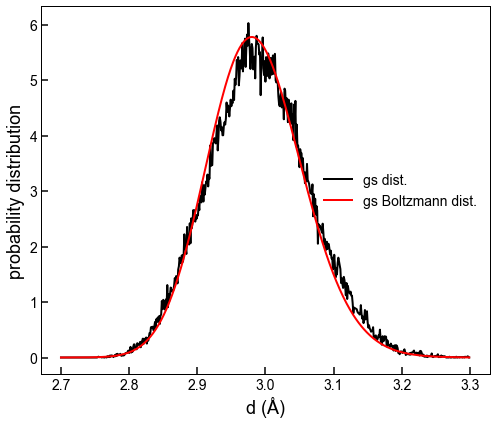

In [6]:
'''Make histogram of distances and compare to Boltzmann distribution
'''

r_bins = np.arange(r[0]-r_step/2, r[-1]+r_step, r_step)

alld = []
for val in d.values():
    [alld.append(i) for i in val]
alld = np.array(alld)

p_gs, bin_edges = np.histogram(alld, bins=r_bins, density=True)

# Check that the distribution is normalized
assert np.allclose(r_bins, bin_edges)
assert np.sum(p_gs * np.diff(bin_edges)) == 1.0

p_gs_boltz = np.exp(- pot_gs / (units.kB * 300))
p_gs_boltz /= np.sum(p_gs_boltz * np.diff(bin_edges))

# Plot distribution
f, ax = plt.subplots(figsize=(7,6))
plot_lines(ax, r, [p_gs, p_gs_boltz], ['gs dist.', 'gs Boltzmann dist.'])
ax.set_xlabel('d (Å)', fontsize=18, fontweight='normal')
ax.set_ylabel('probability distribution', fontsize=18, fontweight='normal')
lgd=plt.legend(loc='center right', fontsize=14)
lgd.draw_frame(False)
f.tight_layout()
plt.show()



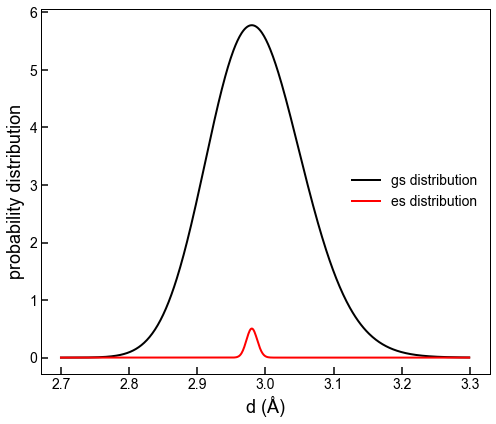

In [7]:
'''Make excited-state distribuion and scale by excitation fraction
'''

hbar = 6.582119569e-16  # eVs, au 1
a = 1.0
tau = 60e-15  # s, au /= 2.4188843265857e-17
e1 = 3.35  # eV, au /= units.Hartree
alpha = 0.01

# Make window function
F = np.exp(- (tau**2 * (pot_es - pot_gs - e1)**2) / (2 * hbar**2))

# Make excited-state distribution
p_es = F**2 * p_gs_boltz

# Scale excited-state distribution to achieve 
# excitation fraction alpha
a = alpha / np.sum(p_es * np.diff(bin_edges))
p_es *= a
assert np.sum(p_es * np.diff(bin_edges)) - alpha < 1e-6

# Plot distributions
f, ax = plt.subplots(figsize=(7,6))
plot_lines(ax, r, [p_gs_boltz, p_es], ['gs distribution', 'es distribution'])
ax.set_xlabel('d (Å)', fontsize=18, fontweight='normal')
ax.set_ylabel('probability distribution', fontsize=18, fontweight='normal')
lgd=plt.legend(loc='center right', fontsize=14)
lgd.draw_frame(False)
f.tight_layout()
plt.show()

Excitation fraction: 0.038


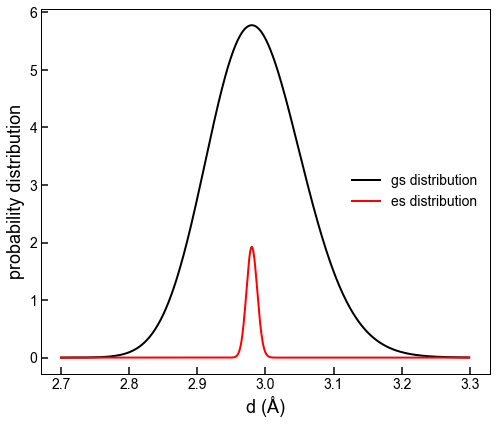

In [8]:
'''Make excited-state distribuion.
   Excitation fraction based on 
   selection rules for excitation with 
   linearly polarized pulse.
'''
# Make excited-state distribution
p_es = F**2 * p_gs_boltz

pratiomax = np.argmax(p_es / p_gs_boltz)
p_es = p_es / p_es[pratiomax] * 1 / 3. * p_gs_boltz[pratiomax]
print('Excitation fraction: %.3f' %(np.sum(p_es * np.diff(bin_edges))))

# Plot distributions
f, ax = plt.subplots(figsize=(7,6))
plot_lines(ax, r, [p_gs_boltz, p_es], ['gs distribution', 'es distribution'])
ax.set_xlabel('d (Å)', fontsize=18, fontweight='normal')
ax.set_ylabel('probability distribution', fontsize=18, fontweight='normal')
lgd=plt.legend(loc='center right', fontsize=14)
lgd.draw_frame(False)
f.tight_layout()
plt.show()

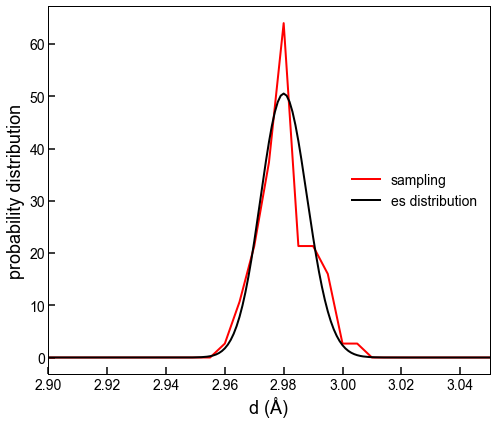

In [14]:
'''Sample frames from ground-state trajectories.
   Random sampling according to excited-state distribution.
'''

# Number of frames to select to start es trajectories
n_es_trajs = 75

p_es /= np.sum(p_es)
d_samp = [np.around(np.random.choice(r, p=p_es), 3) for i in range(n_es_trajs)]
    
r_step_samp = 0.005
r_samp = np.arange(2.70, 3.30, r_step_samp)
r_bins_samp = np.arange(r_samp[0]-r_step_samp/2, r_samp[-1]+r_step_samp, r_step_samp)

p_samp, bin_edges_samp = np.histogram(d_samp, bins=r_bins_samp, density=True)
r_samp = (bin_edges_samp[1::1] + bin_edges_samp[:-1:1]) / 2.

# Normalize distributions to densities
p_es /= np.sum(p_es * np.diff(bin_edges))

# Plot distributions
f, ax = plt.subplots(figsize=(7,6))
plot_lines(ax, r_samp, [p_samp], ['sampling'], colors='r')
plot_lines(ax, r, [p_es], ['es distribution', 'sampling'])
ax.set_xlabel('d (Å)', fontsize=18, fontweight='normal')
ax.set_ylabel('probability distribution', fontsize=18, fontweight='normal')
ax.set_xlim([2.9, 3.05])
lgd=plt.legend(loc='center right', fontsize=14)
lgd.draw_frame(False)
f.tight_layout()
plt.show()

Number of frames to select: 55


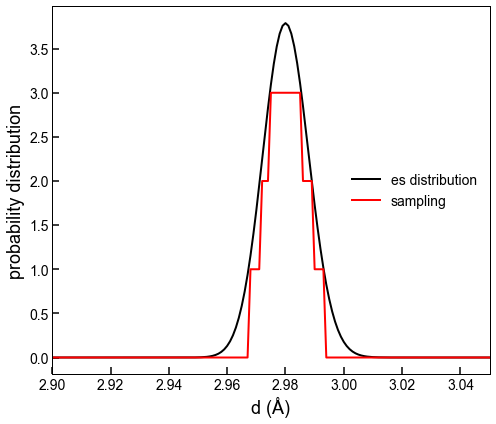

In [9]:
'''Sample frames from ground-state trajectories.
   Convert excited-state distribution to integers.
'''

p_es = p_es / np.sum(p_es) * n_es_trajs
p_es_int = p_es.astype(int)
print('Number of frames to select: %d' %np.sum(p_es_int))

# Plot distributions
f, ax = plt.subplots(figsize=(7,6))
plot_lines(ax, r, [p_es, p_es_int], ['es distribution', 'sampling'])
ax.set_xlabel('d (Å)', fontsize=18, fontweight='normal')
ax.set_ylabel('probability distribution', fontsize=18, fontweight='normal')
ax.set_xlim([2.9, 3.05])
lgd=plt.legend(loc='center right', fontsize=14)
lgd.draw_frame(False)
f.tight_layout()
plt.show()


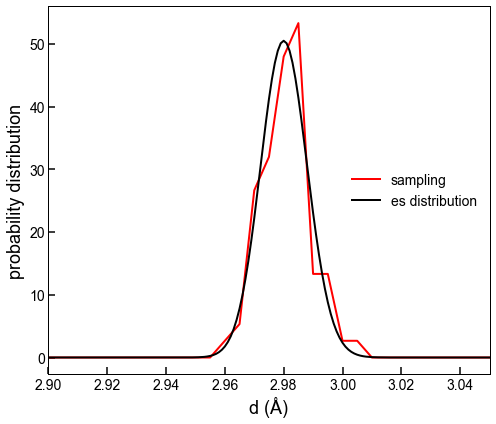

In [10]:
'''Select frames from ground-state trajectories accoring to sampling.
'''

d_rej = {}
for key in d.keys():
    d_rej[key] = np.asarray([True for i in d[key]])

selected_frames = {}
selected_frames['traj_names'] = []
selected_frames['steps'] = []
selected_frames['d'] = []

for i in range(len(d_samp)):
    picked = False
    while not picked:
        # Pick a random frame of a random trajectory
        trajname, trajds = random.choice(list(d.items()))
        step = np.random.randint(len(trajds))
        
        # Select frame if the distance is consistent 
        # with the value we are looking for
        if (np.around(trajds[step], 3) == d_samp[i]) and d_rej[trajname][step]:
            selected_frames['traj_names'].append(trajname)
            selected_frames['steps'].append(step)
            selected_frames['d'].append(trajds[step])
            
            # We don't want to select frames that are close 
            # to each other. Reject frames around the 
            # selected point, so they are not picked later
            if step - 250 < 0:
                lowlim = None
            else: 
                lowlim = step - 250
            if step + 250 > len(trajds):
                highlim = None
            else:
                highlim = step + 250
            d_rej[trajname][lowlim:highlim] = False
            
            picked = True

# Check that we didn't select frames close to each other
for i, traj1 in enumerate(selected_frames['traj_names']):
    for j, traj2 in enumerate(selected_frames['traj_names'][i+1:]):
        if traj1 == traj2:
            assert abs(selected_frames['steps'][i] - selected_frames['steps'][i+1:][j]) > 250 - 1

p_selected, bin_edges_selected = np.histogram(selected_frames['d'], 
                                              bins=r_bins_samp, 
                                              density=True)
r_samp = (bin_edges_samp[1::1] + bin_edges_samp[:-1:1]) / 2.

# Normalize distributions to densities
p_es /= np.sum(p_es * np.diff(bin_edges))

# Plot distributions
f, ax = plt.subplots(figsize=(7,6))
plot_lines(ax, r_samp, [p_selected], ['sampling'], colors='r')
plot_lines(ax, r, [p_es], ['es distribution', 'sampling'])
ax.set_xlabel('d (Å)', fontsize=18, fontweight='normal')
ax.set_ylabel('probability distribution', fontsize=18, fontweight='normal')
ax.set_xlim([2.9, 3.05])
lgd=plt.legend(loc='center right', fontsize=14)
lgd.draw_frame(False)
f.tight_layout()
plt.show()

In [230]:
'''Write selected frames to file.
'''

with open('selected_frames.txt', 'w') as flout:
    for i in range(len(selected_frames['traj_names'])):
        flout.write('%s %6d %10.6f\n' %(selected_frames['traj_names'][i], 
                                   selected_frames['steps'][i], 
                                   selected_frames['d'][i]))
    
